In one of my previous posts I implemented a trend filtering model in the univariate case. This is useful on its own but I want to extend it to the multivariate additive case to make it more useful for real-world modeling. Here I'll consider this model form:
$$
y_i = \alpha + f_1(x_{i, 1}) + f_2(x_{i, 2}) + \ldots + f_k(x_{i, k}) + \epsilon
$$
So, we're assuming that the value of $y$ is a linear function of functions of each of our input variables $x$. In this case each of the smoothing functions, $f_j$ will be fit using the trend filtering method. So, this is a traditional GAM where we're changing the form of the smoothing functions. I'll be again using a least squares fit for simplicity, so we're assuming $\epsilon$ is a standard normal random variable, but this probabilistic interpretation won't matter much here because I'll be focusing more on implementation.

# Synthetic Data

I'll be using synthetic data with a known additive functional form to make sure that the model fitting procedure can properly recover the true underlying function. The function is simple:
$$
y_i = 5 + \sin(x_{i, 1}) + \exp(x_{i, 2}) + \epsilon \\
\epsilon \sim \text{Normal}(\mu = 0, \sigma^2 = 0.5^2)
$$

I'm also simulating the $x$ values in a specific way to ensure some behavior in the values to make sure I can handle common practical issues. Firstly, the total number of values I'm simulating is 10,000, but I'll be sampling integers bounded in such a way that the total number of unique possibilities is smaller than the total number of values I'm sampling. By the pigeonhole principle, this guarantees that I will sample multiple of the same value which ensures that my fitting procedure can deal with data where there are repeated $x$ values. For example, I'm sampling $x_{i, 1}$ as integers from -100 to +100 and then dividing by 10 to get rational values between -10 and 10. There are only 200 unique values possible, but again, I'm sampling 10,000 points, and this guarantees repeated values. In other words, the number of unique values will always be less than 10,000.

Secondly, I'm also making sure that the number of unique values differs between each of the $x$'s. For $x_{i, 1}$ there will be at most 200 unique values, and for $x_{i, 2}$ there will be at most 500. Technically, by random chance they could be the same, but this is *exceedingly* unlikely to happen given 10,000 sample points, so I'm ignoring this possibility. This behavior ensures that my fitting procedure can deal with each input feature having different numbers of unique values, necessitating individual treatment which we'll see later.

In [251]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy
import cvxpy as cp

rng = np.random.default_rng()

In [332]:
# Duplicate values within features and different number of unique values per feature
# duplicates guaranteed because of pigeonhole principle
n = 10000
X = np.hstack(
    [
        rng.integers(-100, 100, size=(n, 1)) / 10,
        rng.integers(-250, 250, size=(n, 1)) / 250,
    ]
)
true_y = 5 + np.sin(X[:, 0]) + np.exp(X[:, 1])
obs_y = true_y + 0.5 * rng.standard_normal(n)

In [333]:
plot_x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
plot_y = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)

x_grid, y_grid = np.meshgrid(plot_x, plot_y)

Z = scipy.interpolate.griddata(
    (X[:, 0], X[:, 1]), true_y, (x_grid, y_grid), method="linear"
)

In [335]:
fig = go.Figure(
    data=[
        go.Surface(x=plot_x, y=plot_y, z=Z),
        go.Scatter3d(
            x=X[:, 0],
            y=X[:, 1],
            z=obs_y,
            opacity=0.1,
            mode="markers",
            marker={"size": 3, "color": "black"},
        ),
    ]
)
fig.show()

In [336]:
def make_D_matrix(n):
    ones = np.ones(n)
    return scipy.sparse.spdiags(np.vstack([-ones, ones]), range(2), m=n - 1, n=n)


params = {}

for i in range(X.shape[1]):
    unique_vals, recon_idx = np.unique(X[:, i], return_inverse=True)
    params[i] = {
        "sort_idx": np.argsort(X[:, i]),
        # These are guaranteed to be sorted
        "unique_vals": unique_vals,
        "recon_idx": recon_idx,
        "D_mat": make_D_matrix(len(unique_vals)),
        "beta_vec": cp.Variable(len(unique_vals), name=f"X_{i}"),
    }

In [337]:
# For each observed y value get the relevant beta coefficient for that X observation
# by using the reconstruction index based on the unique values vector
alpha = cp.Variable(name="alpha")
y_hat = alpha + cp.sum(
    [params[i]["beta_vec"][params[i]["recon_idx"]] for i in params.keys()]
)
# Compute separate l1 norms for each input variable and sum
penalty = cp.sum(
    [cp.norm(params[i]["D_mat"] @ params[i]["beta_vec"], 1) for i in params.keys()]
)

lam = 5
objective = cp.Minimize(0.5 * cp.sum_squares(obs_y - y_hat) + lam * penalty)
constraints = [cp.sum(params[i]["beta_vec"]) == 0 for i in params.keys()]
prob = cp.Problem(objective, constraints)
results = prob.solve(solver="CLARABEL")

In [338]:
fitted_y = alpha.value + np.sum(
    [params[i]["beta_vec"].value[params[i]["recon_idx"]] for i in params.keys()], axis=0
)

In [339]:
fig = go.Figure(
    data=[
        go.Surface(x=plot_x, y=plot_y, z=Z),
        go.Scatter3d(
            x=X[:, 0],
            y=X[:, 1],
            z=fitted_y,
            opacity=0.1,
            mode="markers",
            marker={"size": 3, "color": "black"},
        ),
    ]
)
fig.show()

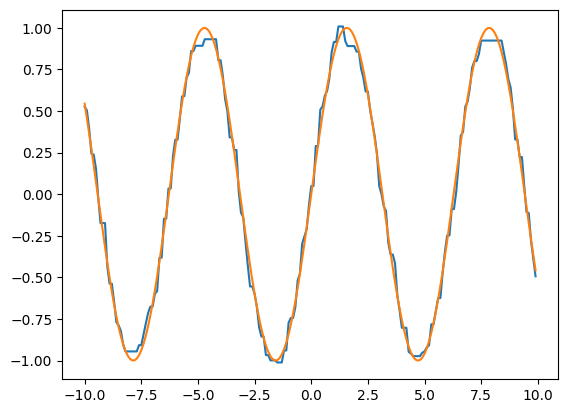

In [340]:
plt.plot(params[0]["unique_vals"], params[0]["beta_vec"].value)
plot_x_0 = np.linspace(
    params[0]["unique_vals"].min(),
    params[0]["unique_vals"].max(),
    len(params[0]["unique_vals"]),
)
plt.plot(plot_x_0, np.sin(plot_x_0))

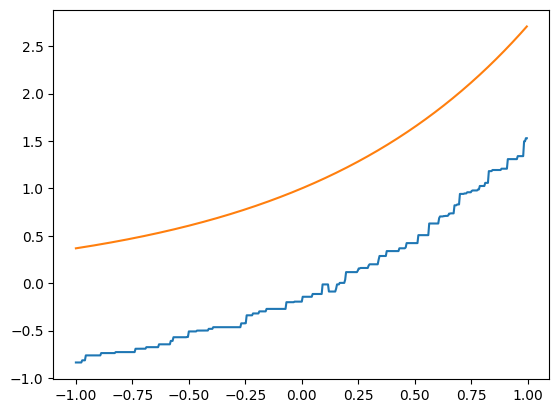

In [341]:
plt.plot(params[1]["unique_vals"], params[1]["beta_vec"].value)
plot_x_1 = np.linspace(
    params[1]["unique_vals"].min(),
    params[1]["unique_vals"].max(),
    len(params[1]["unique_vals"]),
)
plt.plot(plot_x_1, np.exp(plot_x_1))

In [342]:
# TODO: Is there a way to fix this identifiability problem??
# Doesn't matter for prediction purposes because the intercept value perfectly offsets it
# but the variable-wise relationship will be biased.
# Does this matter? The fitted *relationship* is correct.
print(np.exp(plot_x_1[0]) - params[1]["beta_vec"].value[0])
print(alpha.value - 5)

1.2038241419341889
1.1759782516859847
